#### Crucial note (working of this code is dependant)
- The working of this notebook is conditioned on the `uncertain_IDM` model in `AutomotiveDrivingModels
which implements the sensor noise to corrupt headway measurement

#### Changelog
- 30 Sep 2019
    - Creation
    - Goal is to do MOBIL experimentation to demonstrate lane changes
    - Idea flow
        - Look at some videos to select a situation with enough spacing to make lane change
        - Select a vehicle id that is on a slow lane
        - Make it want to make a lange change by some selection of parameters
- 2 Oct
    - Defining in notebook copies of `MOBIL` and `Tim2DDriver` for debugging purposed
    - Above did not work because methods being redefined not working (or something like that)
    - Found that Maxime had a commit on June 18 fixing MOBIL.jl. Did a git pull 
    on `.julia/packages/dev/AutomotiveDrivingModels`
    - Seems to change lane
- 3 Oct
    - Influence of stochastictity on the `ProportionalLaneTracker`
    - trace the x and y positions of car
- 10 Oct
    - Function to get the lane id
- 16 Oct
    - Back to working in this notebook now that upstream dependencies in `AutomotiveDrivingModels.jl`
    have solidified
    - `uncertain_IDM.jl` is a new driver model that has been defined in `AutomotiveDrivingModels/src/behaviors`
    - Global things defined at top of notebook to step away from dictionary based particles
- 17 Oct
    - Uniform sampling to create initial particle matrix
- 18 Oct
    - Likelihood computation works
    - Renamed `compute_particle_likelihoods` to `weight_and_resample` as combined it with previous
    function called `update_p_one_step`
- 22 Oct
    - `multistep_update` works without error
    - rmse computation functions written to compare ground truth versus imitation trajectory
    - Script written for end to end: filtering on ground truth, imitation traj generation, rmse compute,
    and overlay video
    
#### Basic idea of what this notebook does
- Generate initial sample set of particles given some limits on the possible range of each of the parameters
- Use a trajectory of driving behavior as the ground truth and run filtering using sample set of particles
- Get a set of filtered particles. Take the mean of these particles and use it to generate an imitation trajectory
- Evaluate rmse of that imitation trajectory with respect to the ground truth demonstration trajectory

In [132]:
# using packages
using NGSIM
using AutomotiveDrivingModels
using AutoViz
using Reel
using Distributions
using Random
using PGFPlots
using LinearAlgebra # To make the MvNormal covariance work maybe
using JLD
using StatsBase # For weighting particles according to likelihoods and then resampling

In [4]:
# overlays: IDOverlay. my_overlay
"""
    IDOverlay
Display the ID on top of each entity in a scene.
# Fields
- `color::Colorant`
- `font_size::Int64`
"""
mutable struct IDOverlay <: SceneOverlay
    color::Colorant
    font_size::Int
end

function AutoViz.render!(rendermodel::RenderModel, overlay::IDOverlay, scene::Scene, 
                            env::E) where E
    font_size = overlay.font_size
    for veh in scene
        add_instruction!(rendermodel, render_text, ("$(veh.id)", veh.state.posG.x, 
                        veh.state.posG.y, font_size, overlay.color), incameraframe=true)
    end
    return rendermodel
end

"""
    my_overlay
Overlaying hallucinated trajectory on the ground truth
# Fields
- `color::Colorant`
- `scene::Scene`
"""
struct my_overlay <: SceneOverlay
    scene::Scene
    color # Needs to be of form colorant"Colorname"
end

function AutoViz.render!(rendermodel::RenderModel,overlay::my_overlay, 
        scene::Scene, roadway::Roadway)
    AutoViz.render!(rendermodel,overlay.scene,car_color = overlay.color)
    return rendermodel
end

In [102]:
# functions: get_frenet_s, get_lane_id, lane change probability
"""
    function get_frenet_s(scene;car_id=-1)

# Examples
```julia
true_next_pos = get_frenet_s(true_next_scene,car_id=1)
```
"""
function get_frenet_s(scene;car_id=-1)
    if car_id==-1 print("get_frenet_s says: Give valid car id") end
    veh = scene[findfirst(car_id,scene)]
    return veh.state.posF.s
end

"""
    function get_lane_id(scene,car_id)
# Examples
```julia
get_lane_id(scene,1)
```
"""
function get_lane_id(scene,car_id)
    veh = scene[findfirst(car_id,scene)]
    return veh.state.posF.roadind.tag.lane
end

"""
    function get_lane_change_prob(start_scene,particle;car_id=-1,num_samplings=10)
- Probability of lane changing start from `start_scene`
- hallucinating using `particle` for `car_id` using `num_samplings` hallucinations

# Examples
```julia
lp = get_lane_change_prob(scene,particle,car_id = 1)
```
"""
function get_lane_change_prob(start_scene,particle;car_id=-1,num_samplings=10)
    if car_id==-1 @show "get_lane_change_prob says: Please give valid car_id" end
    start_lane = get_lane_id(start_scene,car_id)
    changed_count = 0; unchanged_count = 0
    for i in 1:num_samplings
        hpos,hlane = hallucinate_a_step(start_scene,particle,car_id=car_id)
        if hlane == start_lane
            unchanged_count += 1
	else
	    changed_count += 1
	end
    end
    return changed_count/num_samplings
end

get_lane_change_prob

In [6]:
# function: generate roadway and place cars
"""
    function init_place_cars(lane_place_array;road_length = 1000.0)
- Place cars on a straight roadway of `road_length` according to elems in `lane_place_array`

# Examples
```julia
pos_vel_array_1 = [(200.,30.),(215.,0.),(220.,0.)]
pos_vel_array_2 = [(200.,0.),(215.,0.),(220.,20.)]
pos_vel_array_3 = [(215.,0.),(225.,10.),(230.,0.)]
lane_place_array = [pos_vel_array_1,pos_vel_array_2,pos_vel_array_3]
scene,roadway = init_place_cars(lane_place_array)
```
"""
function init_place_cars(lane_place_array;road_length = 1000.0)
    num_lanes = length(lane_place_array)
    roadway = gen_straight_roadway(num_lanes,road_length)
    scene = Scene()

    id = 1
    for i in 1:num_lanes
        for j in 1:length(lane_place_array[i])
            veh_state = VehicleState(Frenet(roadway[LaneTag(1,i)],
                    lane_place_array[i][j][1]),roadway,
                lane_place_array[i][j][2])
            veh = Vehicle(veh_state,VehicleDef(),id)
            push!(scene,veh)
            id+=1
        end
    end
    return scene,roadway
end

init_place_cars

In [201]:
# function: videos
"""
    function scenelist2video(scene_list;filename = "media/mobil/scene_to_video.mp4")
- Make video from a list of scenes

# Examples
```julia
scenelist2video(scene_list,filename="media/mobil/true_traj.mp4")
```
"""
function scenelist2video(scene_list;filename = "media/mobil/scene_to_video.mp4")
    frames = Frames(MIME("image/png"),fps = 10)
    
    # Loop over list of scenes and convert to video
    for i in 1:length(scene_list)
        scene_visual = render(scene_list[i],ROADWAY,
        [IDOverlay(colorant"white",12)],
#         cam=FitToContentCamera(0.),
        cam = CarFollowCamera(1)
        )
        push!(frames,scene_visual)
    end
    print("Making video filename: $(filename)\n")
    write(filename,frames)
    return nothing
end

"""
    function scenelist2video
- Make video from two different scene lists overlaying `scene_list_2` in blue on top of `scene_list_1` in pink

# Examples
```julia
multiple_scenelist2video(true_scene_list,imit_scene_list,filename="media/mobil/true_vs_imitation.mp4")
```
"""
function multiple_scenelist2video(scene_list_1,scene_list_2;
    filename = "media/mobil/multiple_scene_to_video.mp4")
    frames = Frames(MIME("image/png"),fps = 10)
    @assert length(scene_list_1) == length(scene_list_2)
    # Loop over list of scenes and convert to video
    for i in 1:length(scene_list_1)
        other_overlay = my_overlay(scene_list_2[i],colorant"blue")
        scene_visual = render(scene_list_1[i],ROADWAY,
        [IDOverlay(colorant"white",12),other_overlay],
#         cam=FitToContentCamera(0.),
        cam = CarFollowCamera(1)
        )
        push!(frames,scene_visual)
    end
    print("Making video filename: $(filename)\n")
    write(filename,frames)
    return nothing
end

"""
- Make a video only taking every 5 timesteps into account from `scene_list`

# Examples
```julia
start_scene = deepcopy(scene_list[10])
scene_list_quantization = get_hallucination_scenes(start_scene; nsteps=90,models=models)
```
"""
function scenelist2video_quantized(scene_list;
    filename = "media/mobil/scene_to_video.mp4")
    frames = Frames(MIME("image/png"),fps = 5)
    
    # Loop over list of scenes and convert to video
    for i in 1:length(scene_list)
	if i%5 == 0
		scene_visual = render(scene_list[i],ROADWAY,
		[IDOverlay(colorant"white",12),TextOverlay(text=["frame=$(i)"],font_size=12)],
	#         cam=FitToContentCamera(0.),
		cam = CarFollowCamera(1)
		)
		push!(frames,scene_visual)
	end
    end
    print("Making video filename: $(filename)\n")
    write(filename,frames)
    return nothing
end

scenelist2video_quantized

In [79]:
# functions [plots]:ytrace,lanes,overlay ytraces
"""
    function scenelist2ytrace(scene_list;car_id=-1)
- Make a y position trace from a list of scenes

# Examples
```julia
scenelist2ytrace(scene_list,car_id=1)
```
"""
function scenelist2ytrace(scene_list;car_id=-1)
    if car_id == -1 print("Please provide a valid car_id\n") end

    p = PGFPlots.Plots.Scatter(collect(1:length(scene_list)),
        [scene[findfirst(car_id,scene)].state.posG.y for scene in scene_list],legendentry="y trace")
    return p
end

"""
    function overlay_jld_scenelists(num_exps)
- To assess impact of headway sensor noise
- Capture scene_lists from stored .jld files of `num_exps` experiments

# Examples
``` julia
# Suppose we have 1.jld, 2.jld,...,8.jld
overlay_jld_scenelists(8)
```
"""
function overlay_jld_scenelists(num_exps)
    horizon = 100
    list_of_plots = PGFPlots.Plot[]
    for i in 1:num_exps
        scene_list = JLD.load("media/mobil/$(i).jld","scene_list")
        p = PGFPlots.Plots.Scatter(collect(1:horizon),
            [scene[1].state.posG.y for scene in scene_list[1:horizon]],
            legendentry = "scenario $(i)")
        push!(list_of_plots,p)
    end
    pa = PGFPlots.Axis(list_of_plots,xlabel="timestep",ylabel="y pos",
        legendPos="outer north east")
    display(pa)
    PGFPlots.save("media/mobil/sensor_noise_impact.pdf",pa)
    return nothing
end

"""
    function plot_lanes(scene_list_1)
- Goal is to plot lanes on a y trace of vehicles using `scene_list_1`

# Examples
```julia
plot_lanes(scene_list)
```
"""
function plot_lanes(scene_list_1)
    laneboundary0 = PGFPlots.Plots.Linear(x[:,1],fill(-1.5,length(scene_list_1)),
        style="black,ultra thick",legendentry="lane edge")
    laneboundary1 = PGFPlots.Plots.Linear(x[:,1],fill(1.5,length(scene_list_1)),style="black,ultra thick")
    laneboundary2 = PGFPlots.Plots.Linear(x[:,1],fill(4.5,length(scene_list_1)),style="black,ultra thick")
    return [laneboundary0,laneboundary1,laneboundary2]
end

plot_lanes

In [127]:
# function: hallucinate scene list
"""
    function get_hallucination_scenes
- Hallucinate starting from `start_step` for `nsteps` using `models` and return a list of scenes
- Used by `plot_carwise_pos_vel` to assess position and velocity traces against ground truth

# Returns
- `halluc_scenes_list`: List containing the scenes starting with the ground truth scene at `start_step`

# Examples
```julia
scene_list = get_hallucination_scenes(start_scene,nsteps=100,models=models);
```
"""
function get_hallucination_scenes(start_scene;nsteps,models,start_step=1,
        id_list=[],verbosity = false)
        # Setting up
    scene_halluc = start_scene
    halluc_scenes_list = []
    push!(halluc_scenes_list,deepcopy(start_scene))
#     scene_halluc = get_scene(start_step,traj) # Frame to start hallucination from
#     push!(halluc_scenes_list,deepcopy(scene_halluc))
    
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        
#         if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

            # Propagation of scene forward
        get_actions!(actions,scene_halluc,ROADWAY,models)

        tick!(scene_halluc,ROADWAY,actions,TIMESTEP)
        
        push!(halluc_scenes_list,deepcopy(scene_halluc))
    end 
    return halluc_scenes_list
end

get_hallucination_scenes

In [78]:
# function: Generate uniform sampling to start the initial particle matrix
"""
    function initial_pmat(;limits,num_particles,seed)
- Generate initial particle matrix with `num_particles` particles with every col being a diff particle
- Range of values that parameters can take is specified in `limits`. Should be num_params rows x 2 cols

# Examples
```julia
limits = [10. 40.;0.1 10.;0.5 5.;1. 10.;0. 1.;-1. 1.;-20. 20.]
initial_pmat(limits=limits,num_particles=10,seed=4)
```
"""
function initial_pmat(;limits,num_particles,seed)
    Random.seed!(seed)
    num_params = size(limits,1)
    p_mat = fill(0.,num_params,num_particles)

    for i in 1:num_params
        p_mat[i,:] = rand(Uniform(limits[i,1],limits[i,2]),1,num_particles)
    end
    return p_mat
end

initial_pmat

In [137]:
# function: hallucinate_a_step
"""
    function hallucinate_a_step(scene_input,particle;car_id=-1)
- Hallucinate one step starting from `scene_input` using parameters given by `particle`

# Examples
```julia
limits = [10. 40.;0.1 10.;0.5 5.;1. 10.;0. 1.;-1. 1.;0. 20.]
init_pmat = initial_pmat(limits=limits,num_particles=10,seed=4)
hallucinate_a_step(SCENE,init_pmat[:,9],car_id=1)
```
"""
function hallucinate_a_step(scene_input,particle;car_id=-1)
    if car_id==-1 @show "hallucinate_a_step says: Please give a valid car_id" end

    scene = deepcopy(scene_input)
    models = Dict{Int64,DriverModel}()

    for veh in scene
        if veh.id == car_id
            models[veh.id] = Tim2DDriver(TIMESTEP,
                                    mlane=MOBIL(TIMESTEP,politeness=particle[POLITENESS],
                                                advantage_threshold=particle[ADV_TH],
                                                mlon=uncertain_IDM(sigma_sensor=particle[SENSOR_SIGMA])
                                    ),
                                    mlon = IntelligentDriverModel(v_des=particle[V_DES],σ=particle[SIGMA_IDM],
                                            T=particle[T_HEADWAY],s_min=particle[S_MIN]
                                    )
                            )
        else
            models[veh.id] = IntelligentDriverModel(v_des=50.)
        end
    end

    actions = Array{Any}(undef,length(scene))
    get_actions!(actions,scene,ROADWAY,models)
    tick!(scene,ROADWAY,actions,TIMESTEP)

    halluc_state = scene.entities[findfirst(car_id,scene)].state
    halluc_pos = halluc_state.posF.s
    halluc_lane = get_lane_id(scene,car_id)

    return halluc_pos,halluc_lane
end

hallucinate_a_step

In [179]:
# function: weight and resample
"""
    function weight_and_resample(start_scene,true_nextpos,true_nextlane,p_mat;car_id=-1)
- Hallucination from `start_scene` 
- Compare against ground truth at `true_nextpos`, `true_nextlane`
- Assign weights to particles
- Perform resampling and return a new matrix of particles and associated weight vector

# Examples
```julia
# Test for one step on initial particle matrix
limits = [10. 40.;0.1 10.;0.5 5.;1. 10.;0. 1.;-1. 1.;0. 20.]
init_pmat = initial_pmat(limits=limits,num_particles=10,seed=4)
id = 1
true_next_scene = deepcopy(true_scene_list[2])
true_nextpos = get_frenet_s(true_next_scene;car_id=id)
true_nextlane = get_lane_id(true_next_scene,id)
weight_and_resample(SCENE,true_nextpos,true_nextlane,init_pmat,car_id=id)
```
"""
function weight_and_resample(start_scene,true_nextpos,true_nextlane,p_mat;car_id=-1,verbosity=false)
    if car_id==-1 @show "compute_particle_likelihood says: Please give valid car_id" end
    num_p = size(p_mat,2)
    lkhd_vec = Array{Float64}(undef,num_p)
    for i in 1:num_p
        if verbosity print("w_and_resample says: particle number = $i \n") end
        particle = p_mat[:,i]
        
        std_dev_acc = p_mat[SIGMA_IDM]
        if std_dev_acc <= 0 std_dev_acc = 0.1 end
        std_dev_pos = TIMESTEP*TIMESTEP*std_dev_acc
        hpos,hlane = hallucinate_a_step(start_scene,particle,car_id=car_id)
        
        start_lane = get_lane_id(start_scene,car_id)
        lane_has_changed = false

        if start_lane != true_nextlane
            lane_has_changed = true
        end

        p_lanechange = get_lane_change_prob(start_scene,particle,car_id=car_id)

        prob_lane = 0.5 # Initialize to random
        if lane_has_changed
            prob_lane = p_lanechange
        else
            prob_lane = 1-p_lanechange
        end
        
        prob_pos = pdf(Normal(hpos,std_dev_pos),true_nextpos)
        if verbosity
            print("weight and resample says: true_nextpos = $(true_nextpos) and hpos=$(hpos) and hlane=$(hlane)\n")
            print("weight and resample says: prob_pos = $(prob_pos) and prob_lane=$(prob_lane)\n")
        end
        lkhd_vec[i] = prob_lane*prob_pos
    end
    p_weight_vec = StatsBase.weights(lkhd_vec./sum(lkhd_vec)) # Convert to weights form to use julia sampling
    
    idx = sample(1:num_p,p_weight_vec,num_p)
    if verbosity print("weight and resample says: ids are $(idx)\n") end
    new_p_mat = p_mat[:,idx] #Careful that idx is (size,1) and not (size,2)
    
    return new_p_mat, p_weight_vec
end

weight_and_resample

#### functions under development

In [183]:
# function: multistep_update
"""
- Run filtering over a trajectory by starting from a true scene
- Repeatedly calls `weight_and_resample` on a demonstration trajectory

# Caveats
- Hard coded usage of `true_scene_list` which is basically ground truth generated by `get_hallucination_scenes`
- Hard coded limits on initial particle distribution generation

# Returns
- `final_p_mat`: Matrix with particles in separate columns
- `iterwise_p_mat`: A list with the associated particle matrix at each iteration

# Examples
```julia
final_p_mat,iterwise_p_mat = multistep_update(car_id=1,start_frame=2,last_frame=99)
```
"""
function multistep_update(;car_id,start_frame,last_frame,num_p=500,seed=1,verbosity=false)
    if verbosity print("car id = $(car_id)\n") end
        
        # Careful selectin of particles around initial velocity of data
        # Commented out for now as we are not yet at the stage of using TRAJ
    #startscene = get_scene(start_frame,TRAJ)
    #startpos,startvel = get_veh_info(startscene,car_id=car_id)
    #init_p_mat = sample_init_particles(num_p,v=startvel)

    limits = [10. 40.;0.1 10.;0.5 5.;1. 10.;0. 1.;-1. 1.;0. 20.]
    p_mat = initial_pmat(limits=limits,num_particles=num_p,seed=seed)
    iterwise_p_set = [] # Stores particle set at every iteration
    push!(iterwise_p_set,p_mat)
    
    for framenum in start_frame:last_frame
            # Get the truth from TRAJ
        #scene = get_scene(framenum+1,TRAJ)
        #trupos,truvel = get_veh_info(scene,car_id=car_id,traj=traj)
        
            # Get the scene to start hallucinating from
        #scene = get_scene(framenum,TRAJ)
        scene = deepcopy(true_scene_list[framenum])
        true_next_scene = deepcopy(true_scene_list[framenum+1])
        true_nextpos = get_frenet_s(true_next_scene;car_id=car_id)
        true_nextlane = get_lane_id(true_next_scene,id)
        print("multistep update says: true_nextpos = $(true_nextpos), true_nextlane=$(true_nextlane)\n")
        p_mat_new, weight_vec = weight_and_resample(scene,true_nextpos,true_nextlane,p_mat,car_id=car_id)

            # Addition of dithering noise
        #params = [:v_des,:σ]
        #p_mat = addnoise(p_mat_new, weight_vec)
        
        p_mat = p_mat_new # No noise addition for now
        
            # Storage into list that contains particle matrix at every step
        push!(iterwise_p_set,p_mat)
    end

        # Find the mean particle after filtering is over
        # Defined in `admin.jl`
    mean_particle = mean(p_mat,dims=2)
    
    return mean_particle,iterwise_p_set
end

multistep_update

In [184]:
# Run multistep update and take the mean of the final particle set
final_p_mat,iterwise_p_mat = multistep_update(car_id=1,start_frame=2,last_frame=99);
mean(final_p_mat,dims=2)

multistep update says: true_nextpos = 205.81999999999994, true_nextlane=1
multistep update says: true_nextpos = 208.59499999999994, true_nextlane=1
multistep update says: true_nextpos = 211.27999999999994, true_nextlane=1
multistep update says: true_nextpos = 213.87499999999994, true_nextlane=1
multistep update says: true_nextpos = 216.37999999999994, true_nextlane=1
multistep update says: true_nextpos = 218.79499999999993, true_nextlane=1
multistep update says: true_nextpos = 221.1199999999999, true_nextlane=1
multistep update says: true_nextpos = 223.3549999999999, true_nextlane=1
multistep update says: true_nextpos = 225.49999999999991, true_nextlane=1
multistep update says: true_nextpos = 227.55499999999992, true_nextlane=1
multistep update says: true_nextpos = 229.51999999999992, true_nextlane=1
multistep update says: true_nextpos = 231.40246288391313, true_nextlane=1
multistep update says: true_nextpos = 233.21636572533697, true_nextlane=1
multistep update says: true_nextpos = 23

7×1 Array{Float64,2}:
 30.442440886985523  
  0.2442286556530038 
  1.375357495713998  
  7.458660303593784  
  0.09860591098985383
  0.7926506264131341 
  8.530683686879543  

In [189]:
# function: gen_imitation_traj
"""
    function gen_imitation_traj(p_mat)
- Generate an imitation trajectory using the mean particle obtained from `p_mat`
- `p_mat` is the resulting particle matrix after running `multistep_update`
i.e. obtained after running particle filtering over a trajectory

# Examples
```julia
imit_scene_list = gen_imitation_traj(final_p_mat,SCENE,start_step=1,nsteps=100,car_id=1)
```
"""
function gen_imitation_traj(p_mat,start_scene;start_step,nsteps,id_list=[],car_id=-1)
    particle = mean(p_mat,dims=2)
    models = Dict{Int64,DriverModel}()

    for veh in scene
        if veh.id == car_id
            models[veh.id] = Tim2DDriver(TIMESTEP,
                                    mlane=MOBIL(TIMESTEP,politeness=particle[POLITENESS],
                                                advantage_threshold=particle[ADV_TH],
                                                mlon=uncertain_IDM(sigma_sensor=particle[SENSOR_SIGMA])
                                    ),
                                    mlon = IntelligentDriverModel(v_des=particle[V_DES],σ=particle[SIGMA_IDM],
                                            T=particle[T_HEADWAY],s_min=particle[S_MIN]
                                    )
                            )
        else
            models[veh.id] = IntelligentDriverModel(v_des=50.)
        end
    end
    
            # Setting up
    scene_halluc = start_scene
    halluc_scenes_list = []
    push!(halluc_scenes_list,deepcopy(start_scene))
#     scene_halluc = get_scene(start_step,traj) # Frame to start hallucination from
#     push!(halluc_scenes_list,deepcopy(scene_halluc))
    
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        
#         if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

            # Propagation of scene forward
        get_actions!(actions,scene_halluc,ROADWAY,models)

        tick!(scene_halluc,ROADWAY,actions,TIMESTEP)
        
        push!(halluc_scenes_list,deepcopy(scene_halluc))
    end 
    return halluc_scenes_list
end

gen_imitation_traj

In [195]:
# function: compute rmse of generated trajectory vs true trajectory
"""
    function compute_rmse(true_scene_list,halluc_scene_list;id_list)
- Compute rmse position and velocity between `halluc_scene_list` and `true_scene_list`
- `true_scene_list` is the ground truth demonstration trajectory
- `imit_scene_list` is generated by running vehicles using parameters that we want for the driver model

# Returns
- `rmse_pos::Dict{Int64,Vector{Float64}}`: Key is vehid. Value is array. Each elem is timewise rmse pos value for that veh_id
- `rmse_vel::Dict{Int64,Vector{Float64}}`: Key is vehid. Value is array. Each elem is timewise rmse vel value for that veh_id

# Examples
```julia
rmse_pos_dict,rmse_vel_dict = compute_rmse(true_scene_list,imit_scene_list,id_list=[1,2,3])
```
"""
function compute_rmse(true_scene_list,imit_scene_list;id_list=[])
    @assert length(true_scene_list) == length(imit_scene_list)
    rmse_pos = Dict{Int64,Vector{Float64}}()
    rmse_vel = Dict{Int64,Vector{Float64}}()
    
    for veh_id in id_list
        rmse_pos[veh_id] = []
        rmse_vel[veh_id] = []
    end
    
    for i in 1:length(true_scene_list)
        scene_halluc = imit_scene_list[i]
        demo_scene_target = true_scene_list[i]
        
        for veh_id in id_list
            demo_veh = demo_scene_target[findfirst(veh_id,demo_scene_target)]
            ego_veh = scene_halluc[findfirst(veh_id,scene_halluc)]

            push!(rmse_pos[veh_id],norm(demo_veh.state.posG[1:2]-ego_veh.state.posG[1:2]))
            push!(rmse_vel[veh_id],norm(demo_veh.state.v - ego_veh.state.v))
        end
    end
    return rmse_pos,rmse_vel
end

compute_rmse

In [187]:
# function: Combine carwise rmse into one metric by averaging over cars
"""
    function rmse_dict2mean(rmse_dict)
- Take dict of carwise rmse value and return an array with mean of rmse taken over cars

# Examples
```julia

```
"""
function rmse_dict2mean(rmse_dict)
    num_veh = length(collect(keys(rmse_dict))) # Find length of the vector of keys
    num_iter = length(rmse_dict[collect(keys(rmse_dict))[1]]) # Find length of value contained in 1st key
    rmse_array = fill(0.,num_iter,num_veh)

    i = 0
    for (k,v) in rmse_dict
        i = i+1
        rmse_vals = reshape(v,length(v),1)
        rmse_array[:,i] = rmse_vals
    end

    carmean_rmse = mean(rmse_array,dims=2)
    return carmean_rmse
end

rmse_dict2mean

In [190]:
imit_scene_list = gen_imitation_traj(final_p_mat,SCENE,start_step=1,nsteps=100,car_id=1);

In [196]:
rmse_pos_dict,rmse_vel_dict = compute_rmse(true_scene_list,imit_scene_list,id_list=[1,2,3])

(Dict(2=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  27.1353, 28.4209, 29.7364, 31.0815, 32.4563, 33.8606, 35.2943, 36.7575, 38.2499, 39.7717],3=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  12.7811, 13.6315, 14.5113, 15.4207, 16.3596, 17.3282, 18.3263, 19.3542, 20.4118, 21.4991],1=>[0.0, 0.00079135, 0.00138763, 0.000905303, 0.00439776, 0.00828433, 0.0112669, 0.0125885, 0.0148604, 0.0156359  …  5.51215, 5.6298, 5.74166, 5.84863, 5.95056, 6.04623, 6.13724, 6.22361, 6.30607, 6.38504]), Dict(2=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  12.7071, 13.0058, 13.3033, 13.5999, 13.8955, 14.1904, 14.4845, 14.7781, 15.0712, 15.3638],3=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  8.35677, 8.65109, 8.94598, 9.24139, 9.53725, 9.83352, 10.1302, 10.4272, 10.7244, 11.022],1=>[0.0, 0.015827, 0.00390135, 0.0419574, 0.0278919, 0.0498396, 0.00981248, 0.0166186, 0.0288196, 0.0133106  …  1.39477, 1.33949, 1.26704, 1.22535, 1.14512, 1.07255, 1.02866, 0.957136, 0.930287,

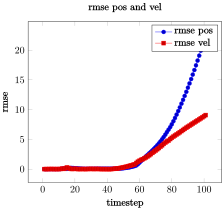

In [199]:
rmse_pos = rmse_dict2mean(rmse_pos_dict)
rmse_vel = rmse_dict2mean(rmse_vel_dict)
rmse_pos = reshape(rmse_pos,length(rmse_pos),)
rmse_vel = reshape(rmse_vel,length(rmse_vel),)
p_pos = PGFPlots.Plots.Linear(collect(1:length(rmse_pos)),rmse_pos,legendentry="rmse pos")
p_vel = PGFPlots.Plots.Linear(collect(1:length(rmse_vel)),rmse_vel,legendentry="rmse vel")
PGFPlots.Axis([p_pos,p_vel],xlabel="timestep",ylabel="rmse",title="rmse pos and vel")

In [202]:
multiple_scenelist2video(true_scene_list,imit_scene_list,filename="media/mobil/true_vs_imitation.mp4")

Making video filename: media/mobil/true_vs_imitation.mp4


In [ ]:
# Script: Filter, imitate, rmse, overlay video
final_p_mat,iterwise_p_mat = multistep_update(car_id=1,start_frame=2,last_frame=99);
imit_scene_list = gen_imitation_traj(final_p_mat,SCENE,start_step=1,nsteps=100,car_id=1)
rmse_pos_dict,rmse_vel_dict = compute_rmse(true_scene_list,imit_scene_list,id_list=[1,2,3])
rmse_pos = rmse_dict2mean(rmse_pos_dict);rmse_vel = rmse_dict2mean(rmse_vel_dict)
rmse_pos = reshape(rmse_pos,length(rmse_pos),);rmse_vel = reshape(rmse_vel,length(rmse_vel),)
p_pos = PGFPlots.Plots.Linear(collect(1:length(rmse_pos)),rmse_pos,legendentry="rmse pos")
p_vel = PGFPlots.Plots.Linear(collect(1:length(rmse_vel)),rmse_vel,legendentry="rmse vel")
PGFPlots.Axis([p_pos,p_vel],xlabel="timestep",ylabel="rmse",title="rmse pos and vel")
multiple_scenelist2video(true_scene_list,imit_scene_list,filename="media/mobil/true_vs_imitation.mp4")

# Scripts

In [82]:
# GLOBAL DEFINITIONS: TIMESTEP, ROADWAY, PARTICLE INDICES
const TIMESTEP = 0.1;
const V_DES = 1; const SIGMA_IDM = 2; const T_HEADWAY = 3; const S_MIN=4; 
const POLITENESS = 5;const ADV_TH = 6;const SENSOR_SIGMA = 7;
const DEFAULT_PARTICLE = [20.,0.,1.5,5.,0.35,0.1,NaN] # The parameters set to default values

pos_vel_array_1 = [(200.,30.),(250.,0.)]
pos_vel_array_2 = [(250.,10.)] #(280.,10.)
pos_vel_array_3 = [(215.,0.),(225.,10.),(230.,0.)]
lane_place_array = [pos_vel_array_1,pos_vel_array_2]
scene,roadway = init_place_cars(lane_place_array)
const SCENE = deepcopy(scene)
const ROADWAY = roadway;

In [130]:
# GROUND TRUTH DATA: Generate ground truth to be imitated
start_step=1
nsteps=100
scene_halluc = deepcopy(SCENE)
models = Dict{Int64,DriverModel}()
for veh in scene models[veh.id] = IntelligentDriverModel() end
models[1] = Tim2DDriver(TIMESTEP,
                        mlane=MOBIL(TIMESTEP),
                        mlon=IntelligentDriverModel(),
            )
models[2] = IntelligentDriverModel(v_des=15.)

true_scene_list = get_hallucination_scenes(scene_halluc,nsteps=100,models=models);
# scenelist2video(true_scene_list,filename="media/mobil/ground_truth.mp4")

test_laneprob.jl says: t=1
test_laneprob.jl says: t=2
test_laneprob.jl says: t=3
test_laneprob.jl says: t=4
test_laneprob.jl says: t=5
test_laneprob.jl says: t=6
test_laneprob.jl says: t=7
test_laneprob.jl says: t=8
test_laneprob.jl says: t=9
test_laneprob.jl says: t=10
test_laneprob.jl says: t=11
test_laneprob.jl says: t=12
test_laneprob.jl says: t=13
test_laneprob.jl says: t=14
test_laneprob.jl says: t=15
test_laneprob.jl says: t=16
test_laneprob.jl says: t=17
test_laneprob.jl says: t=18
test_laneprob.jl says: t=19
test_laneprob.jl says: t=20
test_laneprob.jl says: t=21
test_laneprob.jl says: t=22
test_laneprob.jl says: t=23
test_laneprob.jl says: t=24
test_laneprob.jl says: t=25
test_laneprob.jl says: t=26
test_laneprob.jl says: t=27
test_laneprob.jl says: t=28
test_laneprob.jl says: t=29
test_laneprob.jl says: t=30
test_laneprob.jl says: t=31
test_laneprob.jl says: t=32
test_laneprob.jl says: t=33
test_laneprob.jl says: t=34
test_laneprob.jl says: t=35
test_laneprob.jl says: t=36
t

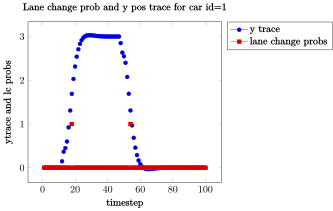

In [12]:
# Generate lane change prob and y pos trace and overlay the two
particle = [29.0,0.5,1.2,1.5,0.,0.1,20.]
start_step = 1; nsteps = 100
scene_halluc = deepcopy(scene)
models = Dict{Int64,DriverModel}()
for veh in scene
    models[veh.id] = uncertain_IDM(sigma_sensor=20.)
end
models[1] = Tim2DDriver(TIMESTEP,mlane=MOBIL(TIMESTEP,politeness=particle[POLITENESS],
        mlon=uncertain_IDM(sigma_sensor=particle[SENSOR_SIGMA])),
    mlon = uncertain_IDM(sigma_sensor=particle[SENSOR_SIGMA]),)
models[2] = uncertain_IDM(v_des=15.,sigma_sensor=particle[SENSOR_SIGMA])

halluc_scenes_list = []
lc_probs = fill(0.,nsteps,)
id = 1
for (i,t) in enumerate(start_step:start_step+nsteps-1)
    print("test_laneprob.jl says: t=$t\n")
    lp = get_lane_change_prob(scene_halluc,particle,car_id=id)
    #print("test_laneprob.jl says lane change prob = $(lp)\n")
    actions = Array{Any}(undef,length(scene_halluc))
    get_actions!(actions,scene_halluc,ROADWAY,models)
    tick!(scene_halluc,ROADWAY,actions,TIMESTEP)
    push!(halluc_scenes_list,deepcopy(scene_halluc))
    lc_probs[i] = lp
end

plot_ytrace = scenelist2ytrace(halluc_scenes_list,car_id=id)
plot_probs = PGFPlots.Plots.Scatter(collect(1:nsteps),lc_probs,legendentry="lane change probs")
pa = PGFPlots.Axis([plot_ytrace,plot_probs],xlabel="timestep",ylabel="ytrace and lc probs",
    legendPos="outer north east",title="Lane change prob and y pos trace for car id=$(id)")
display(pa)
#PGFPlots.save("media/mobil/lc_ytrace.pdf",)

In [ ]:
# Compare two politeness values in one video by overlaying
pos_vel_array_1 = [(200.,30.),(250.,0.)]
pos_vel_array_2 = [(250.,10.)]
pos_vel_array_3 = [(215.,0.),(225.,10.),(230.,0.)]
lane_place_array = [pos_vel_array_1,pos_vel_array_2]
scene,roadway = init_place_cars(lane_place_array)
start_scene = deepcopy(scene)
models_1 = Dict{Int64,DriverModel}()
models_2 = Dict{Int64,DriverModel}()
for veh in scene
    models_1[veh.id] = IntelligentDriverModel()
    models_2[veh.id] = IntelligentDriverModel()
end
politeness = 0.
models_1[1] = Tim2DDriver(timestep_ngsim,mlane=MOBIL(timestep_ngsim,politeness=politeness))
models_1[2] = IntelligentDriverModel(v_des=15.)

scene_list_1 = get_hallucination_scenes(scene,nsteps=100,models=models_1,roadway=roadway)

politeness = 1.
models_2[1] = Tim2DDriver(timestep_ngsim,mlane=MOBIL(timestep_ngsim,politeness=politeness))
models_2[2] = IntelligentDriverModel(v_des=15.)

scene_list_2 = get_hallucination_scenes(start_scene,nsteps=100,models=models_2,roadway=roadway)
multiple_scenelist2video(scene_list_1,scene_list_2,roadway=roadway,
    filename="media/mobil/compare_politeness.mp4")

In [ ]:
# Compare two advantage_threshold values in one video by overlaying
pos_vel_array_1 = [(200.,30.),(250.,0.)]
pos_vel_array_2 = [(250.,10.)]
pos_vel_array_3 = [(215.,0.),(225.,10.),(230.,0.)]
lane_place_array = [pos_vel_array_1,pos_vel_array_2]
scene,roadway = init_place_cars(lane_place_array)
start_scene = deepcopy(scene)
models_1 = Dict{Int64,DriverModel}()
models_2 = Dict{Int64,DriverModel}()
for veh in scene
    models_1[veh.id] = IntelligentDriverModel()
    models_2[veh.id] = IntelligentDriverModel()
end
politeness = 0.
a_th = 0.
models_1[1] = Tim2DDriver(timestep_ngsim,
    mlane=MOBIL(timestep_ngsim,politeness=politeness,advantage_threshold=a_th))
models_1[2] = IntelligentDriverModel(v_des=15.)

scene_list_1 = get_hallucination_scenes(scene,nsteps=100,models=models_1,roadway=roadway)

politeness = 0.
a_th = 1.
models_2[1] = Tim2DDriver(timestep_ngsim,
    mlane=MOBIL(timestep_ngsim,politeness=politeness,advantage_threshold=a_th))
models_2[2] = IntelligentDriverModel(v_des=15.)

scene_list_2 = get_hallucination_scenes(start_scene,nsteps=100,models=models_2,roadway=roadway)
multiple_scenelist2video(scene_list_1,scene_list_2,roadway=roadway,
    filename="media/mobil/compare_adv_blueHighThreshold_p_0.mp4")

In [ ]:
# Influence of stochasticity on lateral driving
seed=3;
Random.seed!(seed) # To control the stochasticity in ProportionalLaneTracker

pos_vel_array_1 = [(200.,30.),(250.,0.)]
pos_vel_array_2 = [(250.,10.)]
pos_vel_array_3 = [(215.,0.),(225.,10.),(230.,0.)]
lane_place_array = [pos_vel_array_1,pos_vel_array_2]
scene,roadway = init_place_cars(lane_place_array)
start_scene = deepcopy(scene)
models_1 = Dict{Int64,DriverModel}()
models_2 = Dict{Int64,DriverModel}()
for veh in scene
    models_1[veh.id] = IntelligentDriverModel()
    models_2[veh.id] = IntelligentDriverModel()
end
models_1[1] = Tim2DDriver(timestep_ngsim,
    mlane=MOBIL(timestep_ngsim),
    mlat=ProportionalLaneTracker()
)
models_1[2] = IntelligentDriverModel(v_des=15.)

scene_list_1 = get_hallucination_scenes(scene,nsteps=100,models=models_1,roadway=roadway)

sigma_lat = 10.
models_2[1] = Tim2DDriver(timestep_ngsim,
    mlane=MOBIL(timestep_ngsim),
    mlat=ProportionalLaneTracker(σ=sigma_lat)
)
models_2[2] = IntelligentDriverModel(v_des=15.)

scene_list_2 = get_hallucination_scenes(start_scene,nsteps=100,models=models_2,roadway=roadway)
multiple_scenelist2video(scene_list_1,scene_list_2,roadway=roadway,
    filename="media/mobil/lateral_blueIsStochastic_$(seed)_seed_sigmaLat_$(sigma_lat).mp4")

# Playground

#### bivariate normal to experiment with the noise in proportional lane tracker

In [ ]:
d = MvNormal([0.,0.],[1. 0.;0. 1.])

In [ ]:
pdf(d,[0.5,-0.5])

In [ ]:
# Lets think of a hybrid discrete and continuous distribution
b = Bernoulli(0.3)
rand(b,50)
pdf(b,0)
d = Normal(0,1)
pdf(b,0)*pdf(d,0.4)